# 1. data import & preprocessing 

In [1]:
import numpy as np
import pandas as pd
import random
np.random.seed(0)
random.seed(0)

### 1) dataset 불러오기
* data50: train set
* data25: test set

In [2]:
data25 = pd.read_csv("data/feature25.csv")
data50 = pd.read_csv("data/feature50.csv")

data25['is_bump40'] = data25['shortest_bump_dist'] < 40
data50['is_bump40'] = data50['shortest_bump_dist'] < 40

data25['is_sidewalk25'] = data25['shortest_sidewalk_dist'] < 25
data50['is_sidewalk25'] = data50['shortest_sidewalk_dist'] < 25

## 2) 사용할 변수 선언

In [3]:
col = {"x_common": ['overspeed_cam_count100', 'floating_pop_count50','car_count1000', 'child_count1000', 
                  'elem_kinder_count400','num_cram_school_count400', 
                  'shortest_cross_dist','shortest_traffic_signal_dist',],
       "x_25" : ['is_bump40', 'parking_count25','is_sidewalk25', 'barrier_nearby_count25',
                   'chaos1_nearby_count25', 'width_nearby_count25','cross_road_nearby_count25',
                   ],
       "x_50" : ['is_bump40', 'parking_count25','is_sidewalk25', 'barrier_nearby_count25',
                   'chaos1_nearby_count25', 'width_nearby_count25','cross_road_nearby_count25'],
       "y_25" : 'accident_count12.5',
       "y_50" : 'accident_count25'}

xy50 = data50[col["x_common"] + col["x_50"] +[col['y_50']]].astype(float)
xy25 = data25[col["x_common"] + col["x_25"] +[col['y_25']]].astype(float)

xy50[col['y_50']] = (xy50[col['y_50']] > 0).astype(float)
xy25[col['y_25']] = (xy25[col['y_25']] > 0).astype(float)

## 3) 사전에 진행한 cluster data 불러오기

In [4]:
kmeans50 = pd.read_csv("data/kmeans_cluster50.csv")
kmeans25 = pd.read_csv("data/kmeans_cluster25.csv")

In [5]:
print(xy50.shape)
print(kmeans50.shape)
print(xy25.shape)
print(kmeans25.shape)

(3912, 16)
(3912, 1)
(7636, 16)
(7636, 1)


## 4) dataset 합치기

In [6]:
xy50=pd.concat([xy50, kmeans50], axis=1)
xy50.rename(columns={'0':'cluster'}, inplace=True)

xy25=pd.concat([xy25, kmeans25], axis=1)
xy25.rename(columns={'0':'cluster'}, inplace=True)

## 5) 사고 방지 장치 데이터 삭제 (도로 자체만의 특성만 반영하기 위해)

In [7]:
xy_train=xy50.drop(['overspeed_cam_count100', 'is_bump40'], axis=1)
xy_test=xy25.drop(['overspeed_cam_count100', 'is_bump40'], axis=1)

## 6) 열 이름 통일 (열 이름이 다르면, model train 후 predict할 때 오류 뜸)

In [8]:
xy_train.rename(columns={'parking_count25':'parking_count', 'is_sidewalk25':'is_sidewalk',
                    'barrier_nearby_count25':'barrier_nearby_count', 'chaos1_nearby_count25':'chaos1_nearby_count',
                     'width_nearby_count25':'width_nearby_count', 'cross_road_nearby_count25':'cross_road_nearby_count',
                     'accident_count25':'accident_count'},inplace=True)
xy_test.rename(columns={'parking_count25':'parking_count', 'is_sidewalk25':'is_sidewalk',
                    'barrier_nearby_count25':'barrier_nearby_count', 'chaos1_nearby_count25':'chaos1_nearby_count',
                     'width_nearby_count25':'width_nearby_count', 'cross_road_nearby_count25':'cross_road_nearby_count',
                     'accident_count12.5':'accident_count'},inplace=True)

## 7) categorical 변수 처리

In [9]:
xy_train['cluster']=xy_train['cluster'].astype('category')
xy_test['cluster']=xy_test['cluster'].astype('category')

In [10]:
xy_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3912 entries, 0 to 3911
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   floating_pop_count50          3912 non-null   float64 
 1   car_count1000                 3912 non-null   float64 
 2   child_count1000               3912 non-null   float64 
 3   elem_kinder_count400          3912 non-null   float64 
 4   num_cram_school_count400      3912 non-null   float64 
 5   shortest_cross_dist           3912 non-null   float64 
 6   shortest_traffic_signal_dist  3912 non-null   float64 
 7   parking_count                 3912 non-null   float64 
 8   is_sidewalk                   3912 non-null   float64 
 9   barrier_nearby_count          3912 non-null   float64 
 10  chaos1_nearby_count           3912 non-null   float64 
 11  width_nearby_count            3912 non-null   float64 
 12  cross_road_nearby_count       3912 non-null   fl

In [11]:
xy_test['cluster'].value_counts()

2    3062
0    2979
3    1143
1     452
Name: cluster, dtype: int64

In [12]:
xy_train=pd.get_dummies(xy_train)
xy_test=pd.get_dummies(xy_test)

## 8) X, y split

In [13]:
X_train=xy_train.drop(['accident_count'], axis=1)
y_train=xy_train['accident_count']

X_test=xy_test.drop(['accident_count'], axis=1)
y_test=xy_test['accident_count']

# 2. Model - XGB Classifier

In [14]:
from xgboost import plot_importance
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer, confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score
from imblearn.over_sampling import SMOTE # unbalanced dataset을 학습시키기 위해, smote 사용하여 oversampling(train set만)

## 1) smote를 이용하여 oversampling (불균형 data를 조정)

In [15]:
sm = SMOTE(random_state=0)
X_resampled, y_resampled = sm.fit_sample(X_train, y_train)

## 2) Bayesian opt

In [16]:
import warnings
import xgboost as xgb
warnings.filterwarnings(action='ignore') 
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

In [17]:
xgtrain = xgb.DMatrix(data=X_resampled, label=y_resampled)

def xgb_eval(n_estimators, learning_rate, max_depth, min_child_weight, num_leaves, subsample, colsample_bytree, gamma):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'n_estimators': int(round(n_estimators)),
        'learning_rate': 0.1,
        'max_depth' : int(round(max_depth)),
        'min_child_weight': int(round(min_child_weight)),
        'num_leaves': int(round(num_leaves)),
        'subsample': 1,
        'colsample_bytree': 1,
        'gamma': 0,
        'verbosity': 0}
    
    cv_result = xgb.cv(params=params,
                       dtrain=xgtrain,
                       nfold=5, seed=0)
    return cv_result['test-auc-mean'].max()

In [18]:
xgbBO = BayesianOptimization(xgb_eval, {'n_estimators': (100, 3000),
                                        'learning_rate': (0.01, 0.1),
                                        'max_depth': (1, 10),
                                        'min_child_weight': (1, 10),
                                        'num_leaves': (20, 40),
                                        'subsample': (0.5, 1),
                                        'colsample_bytree': (0.5, 1),
                                        'gamma': (0, 0.1)}, random_state = 777)

xgbBO.maximize(init_points=10, n_iter=100)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.9526   |  0.5763   |  0.03024  |  0.01558  |  5.139    |  8.517    |  2.788e+0 |  34.54    |  0.8842   |
|  2        |  0.8719   |  0.6346   |  0.0644   |  0.0184   |  1.717    |  6.307    |  1.096e+0 |  39.78    |  0.8132   |
|  3        |  0.9374   |  0.8409   |  0.05523  |  0.0342   |  4.359    |  3.006    |  640.7    |  27.81    |  0.5966   |
|  4        |  0.919    |  0.8055   |  0.08828  |  0.06601  |  3.278    |  2.619    |  2.468e+0 |  24.51    |  0.7584   |
|  5        |  0.8358   |  0.7592   |  0.06004  |  0.05794  |  1.12     |  5.717    |  2.698e+0 |  35.4     |  0.5614   |
|  6        |  0.9522   |  0.6479   |  0.0612   |  0.07535  |  5.171    |  7.922    |  655.7    |  31.16    |  0.7754   |
|  7        |  0.9713   

|  41       |  0.9522   |  0.7047   |  0.004959 |  0.0628   |  4.832    |  8.274    |  1.098e+0 |  22.16    |  0.5106   |
|  42       |  0.9784   |  0.8775   |  0.04299  |  0.04315  |  8.849    |  2.115    |  1.333e+0 |  21.79    |  0.8935   |
|  43       |  0.9798   |  0.5182   |  0.04206  |  0.09241  |  9.624    |  2.12     |  1.543e+0 |  22.04    |  0.6101   |
|  44       |  0.9777   |  0.5851   |  0.01512  |  0.01904  |  7.704    |  1.176    |  1.346e+0 |  22.37    |  0.9197   |
|  45       |  0.9699   |  0.9091   |  0.06401  |  0.07602  |  8.092    |  8.709    |  1.567e+0 |  38.76    |  0.8656   |
|  46       |  0.8358   |  0.6033   |  0.08782  |  0.0688   |  1.399    |  6.64     |  1.542e+0 |  20.83    |  0.8468   |
|  47       |  0.9796   |  1.0      |  0.08501  |  0.09278  |  10.0     |  1.235    |  1.339e+0 |  28.58    |  0.5      |
|  48       |  0.9714   |  0.5      |  0.1      |  0.1      |  10.0     |  10.0     |  1.38e+03 |  25.83    |  1.0      |
|  49       |  0.9798   

|  82       |  0.9796   |  0.9915   |  0.0      |  0.01     |  10.0     |  1.0      |  1.321e+0 |  31.26    |  1.0      |
|  83       |  0.9731   |  0.9102   |  0.03015  |  0.02343  |  9.735    |  8.095    |  1.068e+0 |  24.68    |  0.8565   |
|  84       |  0.9714   |  0.5      |  0.1      |  0.1      |  10.0     |  10.0     |  1.321e+0 |  31.11    |  1.0      |
|  85       |  0.9781   |  0.8201   |  0.05453  |  0.09768  |  9.826    |  3.992    |  1.07e+03 |  33.4     |  0.6853   |
|  86       |  0.979    |  0.7918   |  0.005996 |  0.04359  |  9.482    |  1.05     |  1.066e+0 |  25.71    |  0.8658   |
|  87       |  0.8358   |  0.5609   |  0.06136  |  0.01466  |  1.415    |  9.744    |  1.123e+0 |  39.28    |  0.9777   |
|  88       |  0.9798   |  0.6004   |  0.05483  |  0.05803  |  9.986    |  2.072    |  1.061e+0 |  37.16    |  0.7686   |
|  89       |  0.8358   |  0.8886   |  0.03606  |  0.0256   |  1.042    |  2.198    |  1.066e+0 |  35.77    |  0.7461   |
|  90       |  0.9796   

In [19]:
xgb_params=xgbBO.max['params']
xgb_params['max_depth']=int(round(xgb_params['max_depth']))
xgb_params['n_estimators']=int(round(xgb_params['n_estimators']))
xgb_params['min_child_weight']=int(round(xgb_params['min_child_weight']))
xgb_params['num_leaves']=int(round(xgb_params['num_leaves']))

In [20]:
xgb_params

{'colsample_bytree': 0.5182219992643773,
 'gamma': 0.04205796920017294,
 'learning_rate': 0.0924126523646669,
 'max_depth': 10,
 'min_child_weight': 2,
 'n_estimators': 1543,
 'num_leaves': 22,
 'subsample': 0.6101047022558219}

## 3) f1 score와 confusion matrix 살펴보기

In [21]:
xgb_model = XGBClassifier(params=xgb_params, random_state=0)
xgb_model.fit(X_resampled, y_resampled)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              params={'colsample_bytree': 0.5182219992643773,
                      'gamma': 0.04205796920017294,
                      'learning_rate': 0.0924126523646669, 'max_depth': 10,
                      'min_child_weight': 2, 'n_estimators': 1543,
                      'num_leaves': 22, 'subsample': 0.6101047022558219},
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [22]:
xgb_pred = xgb_model.predict(X_test)

In [23]:
print(f1_score(y_test, xgb_pred))
confusion_matrix(y_test, xgb_pred)

0.47619047619047616


array([[7156,  285],
       [  45,  150]], dtype=int64)

In [24]:
print(f1_score(y_test, xgb_pred, average=None))

[0.9774621  0.47619048]


## 4) ROC curve 그려보기

In [25]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = xgb_model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

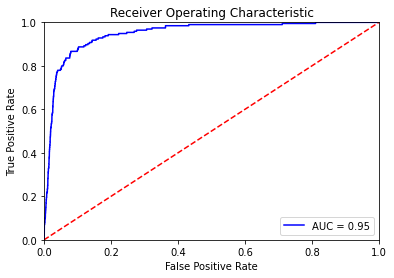

In [26]:
# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 5) cut-off 조정해보면서, Model 성능 재확인

In [27]:
xgb_pred2 = (xgb_model.predict_proba(X_test)[:,1]>=0.5).astype(int)
print('f1 score:', f1_score(y_test, xgb_pred2))
    
confusion_matrix(y_test, xgb_pred2)


f1 score: 0.47619047619047616


array([[7156,  285],
       [  45,  150]], dtype=int64)

## 6) feature importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

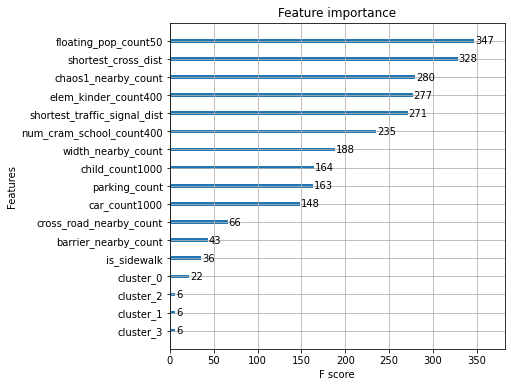

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(6, 6))
plot_importance(xgb_model, ax=ax)

# 3. 결과- 위험지역 뽑아보기

In [29]:
xgb_pred_prob = xgb_model.predict_proba(X_test)

danger_xgb=pd.DataFrame(xgb_pred_prob)
danger_xgb.columns=['No_xgb', 'Yes_xgb']

In [30]:
danger_xgb=pd.concat([data25, danger_xgb], axis=1)
danger_xgb_all=danger_xgb.sort_values(by=['Yes_xgb'], ascending=False)[0:195] #그냥 상위 100개

In [31]:
danger_xgb_without=danger_xgb[danger_xgb['overspeed_cam_count100']==0]
danger_xgb_without=danger_xgb_without.sort_values(by=['Yes_xgb'], ascending=False)[0:195] #카메라 없는 곳 상위 100개

In [32]:
import geopandas as gpd
import json
import folium
from folium import plugins

In [33]:
osan=gpd.read_file("../data/SIG_202005/SIG.shp")
osan=osan[osan["SIG_ENG_NM"]=="Osan-si"]
center = (37.1623799231016, 127.05436890115905)
style5 = {'fillColor': 'skyblue', 'color': 'skyblue'}

map_xgb_danger = folium.Map(location=center, zoom_start=12, width=900, height=700, control_scale=True)

#osan
osan_region = plugins.FeatureGroupSubGroup(map_xgb_danger, 'osan region')
map_xgb_danger.add_child(osan_region)
folium.GeoJson(osan, style_function=lambda x:style5).add_to(osan_region)

fg = folium.FeatureGroup(name='groups')
map_xgb_danger.add_child(fg)

g1 = plugins.FeatureGroupSubGroup(fg, 'group1')
map_xgb_danger.add_child(g1)

g2 = plugins.FeatureGroupSubGroup(fg, 'group2')
map_xgb_danger.add_child(g2)

danger_xgb_all.apply(lambda row: folium.CircleMarker(location=[row['lat'], row['lon']],
                                                radius=2, color='blue').add_to(g1), axis=1)

danger_xgb_without.apply(lambda row: folium.CircleMarker(location=[row['lat'], row['lon']],
                                               radius=2, color='red').add_to(g2), axis=1)

folium.LayerControl(collapsed=False).add_to(map_xgb_danger)
map_xgb_danger

# 4. 최종 위험도 출력

In [34]:
classic=pd.read_csv('data/classic_opt_set.csv')
classic.columns

Index(['Unnamed: 0', 'floating_pop_count50', 'elem_kinder_count400',
       'num_cram_school_count400', 'parking_count25', 'width_nearby_count25',
       'cross_road_nearby_count25', 'lat', 'lon', 'overspeed_cam_count100',
       'is_cross50', 'is_traffic_signal50', 'is_bump40',
       'numberSchoolZone_count400', 'cluster', 'extra50', 'danger', 'index'],
      dtype='object')

In [35]:
modern=classic.drop(['danger'], axis=1)

In [36]:
modern['danger']=xgb_pred_prob[:,1]

In [37]:
modern

,Unnamed: 0,floating_pop_count50,elem_kinder_count400,num_cram_school_count400,parking_count25,width_nearby_count25,cross_road_nearby_count25,lat,lon,overspeed_cam_count100,is_cross50,is_traffic_signal50,is_bump40,numberSchoolZone_count400,cluster,extra50,index,danger
0,0,0.327047,0.032258,0.078341,0.0,0.111111,0.3,37.149281,127.061509,0,True,True,False,0,2,0,0,0.958253
1,1,0.424811,0.032258,0.078341,0.0,0.250000,0.4,37.149503,127.061615,0,True,True,False,0,2,0,1,0.447028
2,2,0.305142,0.032258,0.119816,0.0,0.333333,0.3,37.149617,127.061865,0,True,True,False,0,2,0,2,0.018888
3,3,0.357320,0.032258,0.018433,0.0,0.333333,0.3,37.149433,127.060957,0,True,True,False,0,0,0,3,0.011970
4,4,0.398514,0.032258,0.078341,0.0,0.333333,0.3,37.149457,127.061237,0,True,True,False,0,2,0,4,0.269449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7631,7631,0.054380,0.129032,0.096774,0.0,0.166667,0.0,37.169517,127.060176,0,False,False,False,0,2,0,8851,0.004259
7632,7632,0.057806,0.129032,0.096774,0.0,0.000000,0.0,37.169633,127.060430,0,False,False,False,0,2,0,8852,0.000248
7633,7633,0.025602,0.129032,0.096774,0.0,0.000000,0.0,37.169753,127.060416,0,False,False,False,1,2,0,8853,0.000567
7634,7634,0.053524,0.129032,0.096774,0.0,0.000000,0.0,37.169860,127.060214,0,False,False,False,1,2,0,8854,0.000206


In [38]:
modern.to_csv('modern_opt_set_BO.csv')

In [39]:
import warnings
warnings.simplefilter("ignore")

import numpy as np
import pandas as pd
import folium
import branca
import branca.colormap as cm
from folium import plugins
from folium.plugins import HeatMap
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score,accuracy_score, f1_score


from sklearn.cluster import KMeans, AgglomerativeClustering, Birch
from sklearn.metrics import silhouette_score
from itertools import combinations

center = (37.1623799231016, 127.05436890115905)
# plt.style.use(['ggplot'])
rs = 123
np.random.seed(rs)
random.seed(rs)

<AxesSubplot:xlabel='lon', ylabel='lat'>

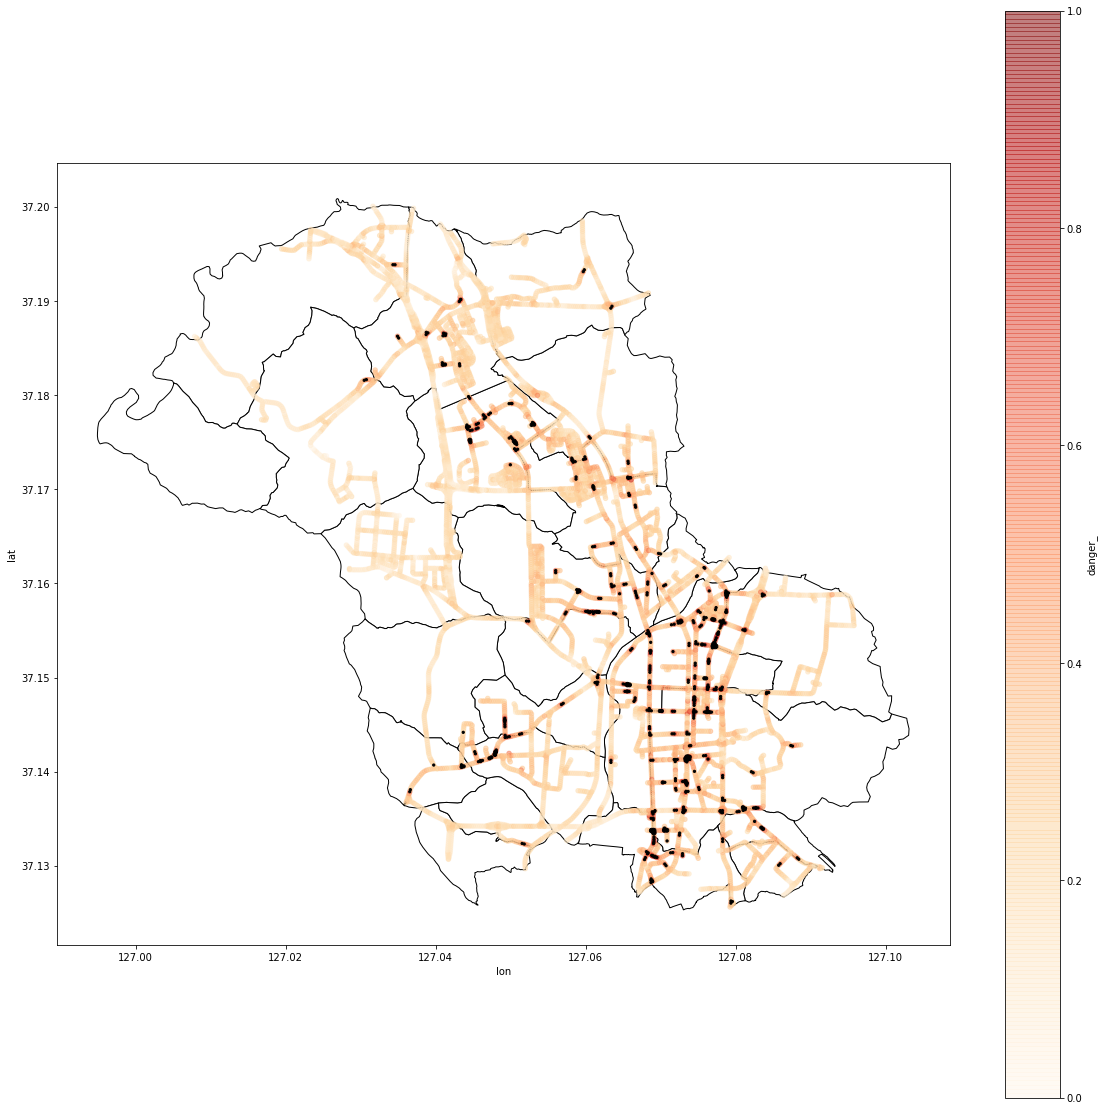

In [40]:
df2 = gpd.read_file('../data/original/33.오산시_법정경계(읍면동).geojson',encoding="utf-8")
fig,ax = plt.subplots(1,1,sharex=True,sharey=True,figsize=(20,20))
df2.plot(ax = ax,color='white', edgecolor='black')
modern["danger_"] = (modern["danger"]/(1-modern["danger"])) ** 0.05
modern["danger_"] = (modern["danger_"] - modern["danger_"].min()) / (modern["danger_"].max() - modern["danger_"].min())

modern.plot.scatter(ax= ax, x='lon',y='lat',c = "danger_", cmap = 'OrRd',alpha = 0.5, s = 20)

data25.plot.scatter(ax= ax, x='lon',y='lat',s = data25['accident_count25'] * 5,c="black")